In [1]:
import pandas
import PIL
import os
import numpy as np
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from IPython.display import display, Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_dir = "/content/drive/My Drive/uc_merced_land_use/images_train_test_val"

In [4]:
import os

model_path = '/content/drive/My Drive/uc_merced_land_use/Models/VGGNet_Model.h5'

if os.path.exists(model_path):
  print(f"File found at: {model_path}")
  model = load_model(model_path, compile=False)
  model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
else:
  print(f"File not found at: {model_path}")
  print("Please check the file path and ensure the file exists.")

File found at: /content/drive/My Drive/uc_merced_land_use/Models/VGGNet_Model.h5


In [5]:
counts = {
    'train': {},
    'test': {},
    'validation': {}
}

def count_images_in_directory(directory):
    label_counts = {}
    total_count = 0
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            image_count = len([file for file in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, file))])
            label_counts[label] = image_count
            total_count += image_count
    return label_counts, total_count

for folder in ['train', 'test', 'validation']:
    folder_path = os.path.join(root_dir, folder)
    counts[folder]['label_counts'], counts[folder]['total_count'] = count_images_in_directory(folder_path)

for folder in ['train', 'test', 'validation']:
    print(f"Folder: {folder}")
    print(f"Total images: {counts[folder]['total_count']}")
    print("Images per label:")
    for label, count in counts[folder]['label_counts'].items():
        print(f"  {label}: {count}")
    print()

Folder: train
Total images: 7360
Images per label:
  mobilehomepark: 350
  river: 360
  overpass: 350
  tenniscourt: 350
  mediumresidential: 350
  sparseresidential: 350
  storagetanks: 350
  runway: 350
  parkinglot: 350
  chaparral: 350
  baseballdiamond: 350
  freeway: 350
  harbor: 350
  buildings: 350
  forest: 350
  intersection: 350
  golfcourse: 350
  denseresidential: 350
  beach: 350
  airplane: 350
  agricultural: 350

Folder: test
Total images: 1050
Images per label:
  mobilehomepark: 50
  parkinglot: 50
  overpass: 50
  runway: 50
  storagetanks: 50
  river: 50
  tenniscourt: 50
  sparseresidential: 50
  beach: 50
  freeway: 50
  forest: 50
  intersection: 50
  golfcourse: 50
  chaparral: 50
  buildings: 50
  mediumresidential: 50
  denseresidential: 50
  harbor: 50
  agricultural: 50
  baseballdiamond: 50
  airplane: 50

Folder: validation
Total images: 2107
Images per label:
  river: 100
  mobilehomepark: 100
  sparseresidential: 100
  parkinglot: 100
  tenniscourt: 100

In [6]:
test_dir = root_dir+'/test'
test_datagen = ImageDataGenerator()

batch_size = 32

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(256, 256), batch_size=batch_size, class_mode='sparse')


Found 1050 images belonging to 21 classes.


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
class_labels = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings',
                'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse',
                'harbor', 'intersection', 'mediumresidential', 'mobilehomepark',
                'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential',
                'storagetanks', 'tenniscourt']

y_true = test_generator.classes  # True labels from the generator
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1) # Get predicted class labels

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 899s 27s/step


In [8]:
misclassified_indices = np.where(y_true != y_pred_classes)[0]

In [9]:
# ... (your previous code for predictions and misclassified_indices)

# Calculate Top-5 Error Rate
top_5_error_count = 0
total_samples = len(y_true)  # Total number of test samples

for i in range(total_samples):
    top_5_predictions = np.argsort(y_pred[i])[-5:]  # Get indices of top 5 predictions
    if y_true[i] not in top_5_predictions:
        top_5_error_count += 1

top_5_error_rate = (top_5_error_count / total_samples) * 100

print(f"Top-5 Error Rate: {top_5_error_rate:.2f}%")

Top-5 Error Rate: 76.76%


In [10]:
def predict_land_all(img_path):
  img = image.load_img(img_path, target_size=(256, 256))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  prediction = model.predict(img_array)[0]

  class_labels = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings',
                  'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse',
                  'harbor', 'intersection', 'mediumresidential', 'mobilehomepark',
                  'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential',
                  'storagetanks', 'tenniscourt']


  sorted_indices = np.argsort(prediction)[::-1]
  sorted_labels = [class_labels[i] for i in sorted_indices]
  sorted_confidences = prediction[sorted_indices]

  predicted_class_index = np.argmax(prediction)
  predicted_class = class_labels[predicted_class_index]
  print(f"Predicted class: {predicted_class}, Confidence: {prediction[predicted_class_index]:.4f}")

  print("\nAll Class Labels with Confidences (Descending Order):")
  for label, confidence in zip(sorted_labels, sorted_confidences):
      print(f"{label}: {confidence:.4f}")

  plt.imshow(img)
  plt.axis('off')
  plt.title(f'Predicted class: {predicted_class}')
  plt.show()

In [11]:
import random
import os

def get_random_image(test_dir):

    label = random.choice(os.listdir(test_dir))

    image_dir = os.path.join(test_dir, label)
    image_file = random.choice(os.listdir(image_dir))

    image_path = os.path.join(image_dir, image_file)

    return image_path, label


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: agricultural, Confidence: 1.0000

All Class Labels with Confidences (Descending Order):
agricultural: 1.0000
chaparral: 0.0000
runway: 0.0000
freeway: 0.0000
golfcourse: 0.0000
airplane: 0.0000
baseballdiamond: 0.0000
beach: 0.0000
buildings: 0.0000
denseresidential: 0.0000
forest: 0.0000
tenniscourt: 0.0000
storagetanks: 0.0000
intersection: 0.0000
mediumresidential: 0.0000
mobilehomepark: 0.0000
overpass: 0.0000
parkinglot: 0.0000
river: 0.0000
sparseresidential: 0.0000
harbor: 0.0000


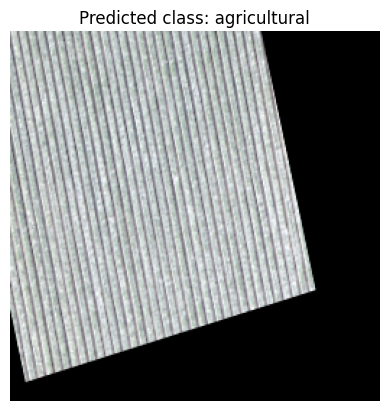

In [12]:
image_path = root_dir +'/test/agricultural/agricultural_000007.png'
predict_land_all(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: tenniscourt, Confidence: 1.0000

All Class Labels with Confidences (Descending Order):
tenniscourt: 1.0000
golfcourse: 0.0000
airplane: 0.0000
baseballdiamond: 0.0000
beach: 0.0000
buildings: 0.0000
chaparral: 0.0000
denseresidential: 0.0000
forest: 0.0000
freeway: 0.0000
harbor: 0.0000
storagetanks: 0.0000
intersection: 0.0000
mediumresidential: 0.0000
mobilehomepark: 0.0000
overpass: 0.0000
parkinglot: 0.0000
river: 0.0000
runway: 0.0000
sparseresidential: 0.0000
agricultural: 0.0000


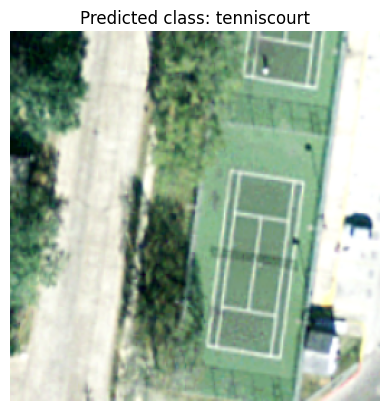

In [13]:
image_path = root_dir +'/test/tenniscourt/tenniscourt_000014.png'
predict_land_all(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
Predicted class: buildings, Confidence: 0.7495

All Class Labels with Confidences (Descending Order):
buildings: 0.7495
mediumresidential: 0.0734
mobilehomepark: 0.0527
denseresidential: 0.0526
storagetanks: 0.0423
tenniscourt: 0.0186
sparseresidential: 0.0048
intersection: 0.0034
parkinglot: 0.0017
baseballdiamond: 0.0006
chaparral: 0.0001
freeway: 0.0001
runway: 0.0001
forest: 0.0001
beach: 0.0000
airplane: 0.0000
overpass: 0.0000
harbor: 0.0000
river: 0.0000
golfcourse: 0.0000
agricultural: 0.0000


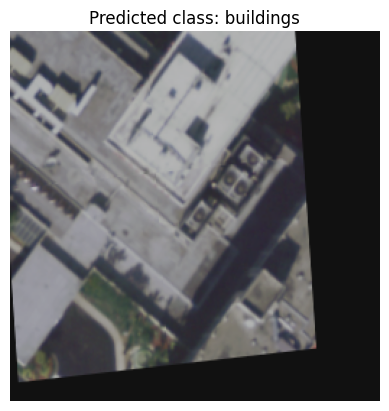

In [14]:
image_path=root_dir+'/test/buildings/buildings_000283.png'
predict_land_all(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
Predicted class: storagetanks, Confidence: 1.0000

All Class Labels with Confidences (Descending Order):
storagetanks: 1.0000
tenniscourt: 0.0000
golfcourse: 0.0000
airplane: 0.0000
baseballdiamond: 0.0000
beach: 0.0000
buildings: 0.0000
chaparral: 0.0000
denseresidential: 0.0000
forest: 0.0000
freeway: 0.0000
harbor: 0.0000
intersection: 0.0000
mediumresidential: 0.0000
mobilehomepark: 0.0000
overpass: 0.0000
parkinglot: 0.0000
river: 0.0000
runway: 0.0000
sparseresidential: 0.0000
agricultural: 0.0000


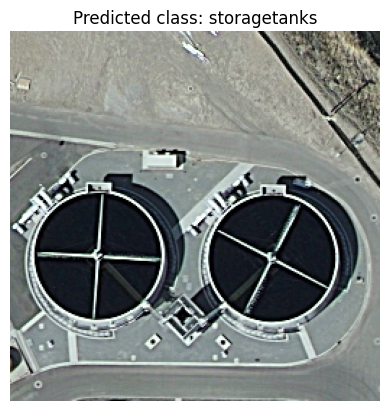

In [15]:
image_path=root_dir+'/test/storagetanks/storagetanks_000201.png'
predict_land_all(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
Predicted class: intersection, Confidence: 1.0000

All Class Labels with Confidences (Descending Order):
intersection: 1.0000
overpass: 0.0000
runway: 0.0000
storagetanks: 0.0000
freeway: 0.0000
baseballdiamond: 0.0000
agricultural: 0.0000
tenniscourt: 0.0000
buildings: 0.0000
airplane: 0.0000
parkinglot: 0.0000
mediumresidential: 0.0000
mobilehomepark: 0.0000
golfcourse: 0.0000
river: 0.0000
forest: 0.0000
denseresidential: 0.0000
chaparral: 0.0000
beach: 0.0000
sparseresidential: 0.0000
harbor: 0.0000


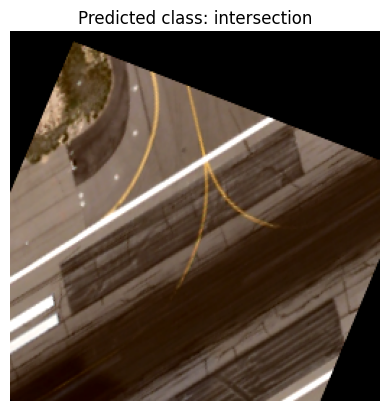

In [16]:
image_path=root_dir+'/test/runway/runway_000072.png'
predict_land_all(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
Predicted class: golfcourse, Confidence: 1.0000

All Class Labels with Confidences (Descending Order):
golfcourse: 1.0000
tenniscourt: 0.0000
airplane: 0.0000
baseballdiamond: 0.0000
beach: 0.0000
buildings: 0.0000
chaparral: 0.0000
denseresidential: 0.0000
forest: 0.0000
freeway: 0.0000
harbor: 0.0000
storagetanks: 0.0000
intersection: 0.0000
mediumresidential: 0.0000
mobilehomepark: 0.0000
overpass: 0.0000
parkinglot: 0.0000
river: 0.0000
runway: 0.0000
sparseresidential: 0.0000
agricultural: 0.0000


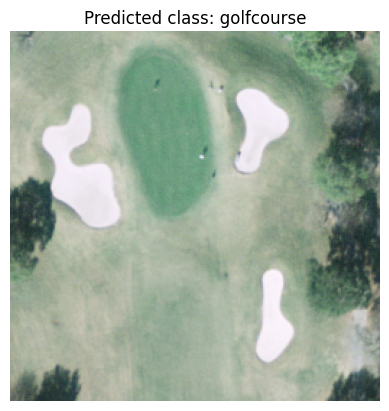

In [17]:
image_path=root_dir+'/test/golfcourse/golfcourse_000313.png'
predict_land_all(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
Predicted class: river, Confidence: 1.0000

All Class Labels with Confidences (Descending Order):
river: 1.0000
beach: 0.0000
golfcourse: 0.0000
harbor: 0.0000
airplane: 0.0000
baseballdiamond: 0.0000
buildings: 0.0000
chaparral: 0.0000
denseresidential: 0.0000
forest: 0.0000
freeway: 0.0000
tenniscourt: 0.0000
storagetanks: 0.0000
intersection: 0.0000
mediumresidential: 0.0000
mobilehomepark: 0.0000
overpass: 0.0000
parkinglot: 0.0000
runway: 0.0000
sparseresidential: 0.0000
agricultural: 0.0000


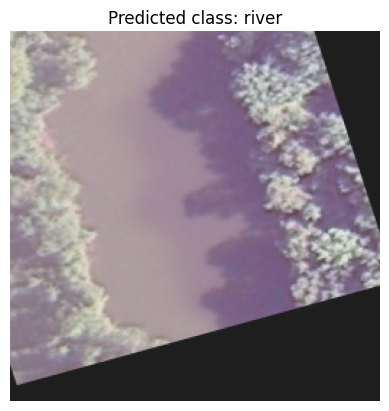

In [18]:
image_path=root_dir+'/test/river/river_000305.png'
predict_land_all(image_path)

In [19]:
def predict_random_land_image():
  test_dir = root_dir+'/test'
  img_path, true_label = get_random_image(test_dir)
  print(f"Random Image Path: {img_path}")
  print(f"True Label: {true_label}")
  predict_land_all(img_path)

Random Image Path: /content/drive/My Drive/uc_merced_land_use/images_train_test_val/test/golfcourse/golfcourse_000048.png
True Label: golfcourse
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
Predicted class: golfcourse, Confidence: 1.0000

All Class Labels with Confidences (Descending Order):
golfcourse: 1.0000
tenniscourt: 0.0000
airplane: 0.0000
baseballdiamond: 0.0000
beach: 0.0000
buildings: 0.0000
chaparral: 0.0000
denseresidential: 0.0000
forest: 0.0000
freeway: 0.0000
harbor: 0.0000
storagetanks: 0.0000
intersection: 0.0000
mediumresidential: 0.0000
mobilehomepark: 0.0000
overpass: 0.0000
parkinglot: 0.0000
river: 0.0000
runway: 0.0000
sparseresidential: 0.0000
agricultural: 0.0000


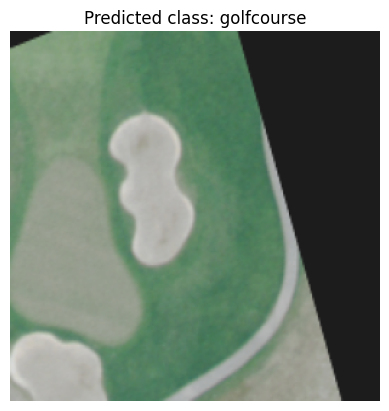

In [20]:
predict_random_land_image()

Random Image Path: /content/drive/My Drive/uc_merced_land_use/images_train_test_val/test/mediumresidential/mediumresidential_000081.png
True Label: mediumresidential
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
Predicted class: mediumresidential, Confidence: 1.0000

All Class Labels with Confidences (Descending Order):
mediumresidential: 1.0000
mobilehomepark: 0.0000
denseresidential: 0.0000
sparseresidential: 0.0000
tenniscourt: 0.0000
buildings: 0.0000
river: 0.0000
harbor: 0.0000
airplane: 0.0000
overpass: 0.0000
intersection: 0.0000
storagetanks: 0.0000
golfcourse: 0.0000
freeway: 0.0000
forest: 0.0000
parkinglot: 0.0000
chaparral: 0.0000
runway: 0.0000
beach: 0.0000
baseballdiamond: 0.0000
agricultural: 0.0000


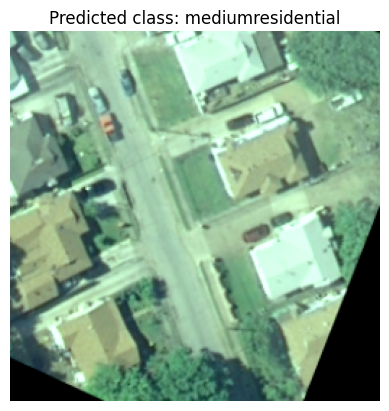

In [21]:
predict_random_land_image()

Random Image Path: /content/drive/My Drive/uc_merced_land_use/images_train_test_val/test/overpass/overpass_000163.png
True Label: overpass
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
Predicted class: overpass, Confidence: 1.0000

All Class Labels with Confidences (Descending Order):
overpass: 1.0000
freeway: 0.0000
runway: 0.0000
intersection: 0.0000
tenniscourt: 0.0000
airplane: 0.0000
baseballdiamond: 0.0000
beach: 0.0000
buildings: 0.0000
chaparral: 0.0000
denseresidential: 0.0000
forest: 0.0000
harbor: 0.0000
golfcourse: 0.0000
storagetanks: 0.0000
mediumresidential: 0.0000
mobilehomepark: 0.0000
parkinglot: 0.0000
river: 0.0000
sparseresidential: 0.0000
agricultural: 0.0000


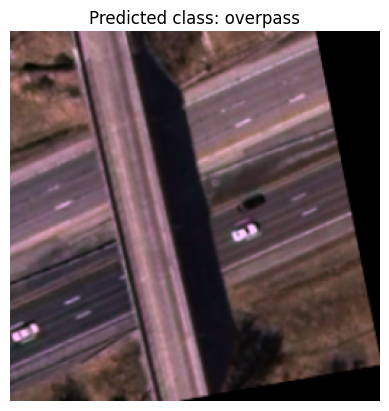

In [22]:
predict_random_land_image()

Random Image Path: /content/drive/My Drive/uc_merced_land_use/images_train_test_val/test/denseresidential/denseresidential_000370.png
True Label: denseresidential
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
Predicted class: intersection, Confidence: 0.9999

All Class Labels with Confidences (Descending Order):
intersection: 0.9999
tenniscourt: 0.0001
buildings: 0.0000
overpass: 0.0000
mediumresidential: 0.0000
baseballdiamond: 0.0000
sparseresidential: 0.0000
denseresidential: 0.0000
storagetanks: 0.0000
airplane: 0.0000
freeway: 0.0000
mobilehomepark: 0.0000
agricultural: 0.0000
parkinglot: 0.0000
harbor: 0.0000
river: 0.0000
chaparral: 0.0000
beach: 0.0000
runway: 0.0000
forest: 0.0000
golfcourse: 0.0000


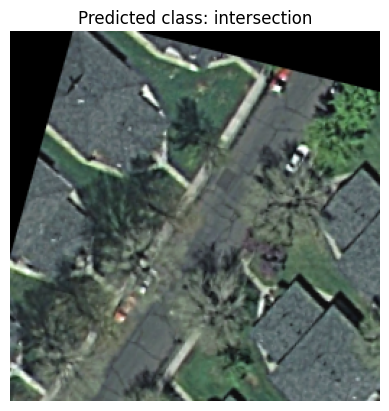

In [23]:
predict_random_land_image()

Random Image Path: /content/drive/My Drive/uc_merced_land_use/images_train_test_val/test/forest/forest_000129.png
True Label: forest
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: forest, Confidence: 1.0000

All Class Labels with Confidences (Descending Order):
forest: 1.0000
river: 0.0000
golfcourse: 0.0000
tenniscourt: 0.0000
airplane: 0.0000
baseballdiamond: 0.0000
beach: 0.0000
buildings: 0.0000
chaparral: 0.0000
denseresidential: 0.0000
freeway: 0.0000
harbor: 0.0000
storagetanks: 0.0000
intersection: 0.0000
mediumresidential: 0.0000
mobilehomepark: 0.0000
overpass: 0.0000
parkinglot: 0.0000
runway: 0.0000
sparseresidential: 0.0000
agricultural: 0.0000


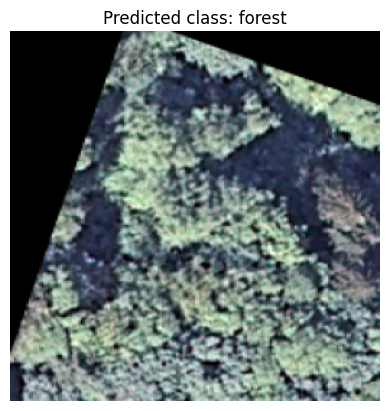

In [24]:
predict_random_land_image()